# Generative Models PHW4: Normalizing Flows

Name:Mohamad Hosein Mehdikhani

Student ID:400102039

## Setup

In [3]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import trange
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from typing import Callable, Optional, Tuple, Union, List
from IPython.display import Image, display

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons, make_circles

In [4]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cpu device


In [5]:
# @title visualization helpers

def visualize(flow, epoch, output_dir='frames', device='cpu'):
    # Create directory for saving frames
    os.makedirs(output_dir, exist_ok=True)

    # Visualization of the learned density
    with torch.no_grad():
        # Create a grid over the range of the data
        xline = torch.linspace(-2, 3, 300, device=device)
        yline = torch.linspace(-1, 1.5, 300, device=device)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
        xyinput = torch.cat([xgrid.reshape(-1, 1),
                             ygrid.reshape(-1, 1)], dim=1).to(device)

        # Compute the log probability for each point in the grid
        log_prob_grid = flow.log_prob(xyinput)  # Compute log probs
        zgrid = torch.exp(log_prob_grid).reshape(300, 300).cpu()  # Convert to probability

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Learned Density at Epoch {epoch}')
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.colorbar(label='Density')

        # Save frame as an image
        filename = os.path.join(output_dir, f'frame_{epoch:03d}.png')
        plt.savefig(filename)
        plt.close()

def create_gif(output_dir='frames', gif_name='density_evolution.gif', fps=10):
    images = []
    for frame in sorted(os.listdir(output_dir)):
        if frame.endswith(".png"):
            images.append(imageio.imread(os.path.join(output_dir, frame)))
    imageio.mimsave(gif_name, images, fps=fps)
    display(Image(filename=gif_name))
    return gif_name

# Dataset (5 points)

Create moons using the `make_moons` dataset from `sklearn.datasets`. You must use `TensorDataset` to create a `DataLoader` for this dataset.

In [6]:

from sklearn.datasets import make_moons
import torch
from torch.utils.data import DataLoader, TensorDataset


X, _ = make_moons(n_samples=1000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)


dataset = TensorDataset(X)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)


for batch in data_loader:
    print(batch)
    break


[tensor([[ 1.6007, -0.3542],
        [-1.0589,  0.1731],
        [-0.4794,  0.6078],
        [-0.0469,  0.1395],
        [-0.1551,  0.9357],
        [ 0.0098,  0.3362],
        [ 1.7423, -0.4354],
        [ 0.9193,  0.2533],
        [ 0.0926,  1.0330],
        [ 1.9174,  0.3089],
        [ 1.4659, -0.5734],
        [-0.1540,  0.9366],
        [ 1.8128, -0.2276],
        [-0.3208,  0.8350],
        [-0.7464,  0.7701],
        [ 0.4023,  0.7187],
        [-0.9862, -0.1688],
        [ 0.0333,  0.0561],
        [ 0.6254,  0.7713],
        [-0.1994,  0.8196],
        [ 0.4890, -0.3996],
        [-0.0062,  0.1736],
        [ 2.0175,  0.2116],
        [-0.7300,  0.6331],
        [ 0.3879,  0.7736],
        [ 1.9747,  0.3045],
        [ 1.8220,  0.2957],
        [ 1.8559, -0.3908],
        [-0.9143,  0.1643],
        [ 0.8395,  0.0552],
        [ 0.8896,  0.4711],
        [-0.9692,  0.1385],
        [ 1.8319, -0.1470],
        [ 0.9424,  0.3350],
        [ 0.1207,  1.1149],
        [ 1.4148, -

# Transformations (30 points)

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [7]:
class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise 'InverseNotAvailable'

First we can create a random permutation transform.

In [8]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now you must:

1. **Scaling and Translation Networks**:
	- Use `self.s_net_factory` and `self.t_net_factory` to initialize the scaling (`s`) and translation (`t`) networks in the `__init__` method.

2. **Forward Pass**:
	-	Pass fixed_inputs through `self.scaling_net` and `self.translation_net` to compute `s` and `t`.

	-	Apply the transformations to `transformed_inputs`.

  - Compute the log-determinant of the Jacobian.

3. **Inverse Pass**:
	-	Solve for `transformed_inputs` by reversing the scaling and translation.

4. **Utility Method **`_initialize_network`:
	-	Use `nn.Sequential`to create a feedforward neural network with the desired hidden dimensions and activation functions.

In [9]:

class CouplingTransform(Transform):

    def __init__(
        self,
        mask: Union[torch.Tensor, list, tuple],
        hidden_dims: int,
        s_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
        t_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
    ):

        super().__init__()


        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dimensional tensor.")
        if mask.numel() == 0:
            raise ValueError("Mask cannot be empty.")
        self.register_buffer('mask', mask)


        self.num_features = mask.numel()


        if not callable(s_net_factory) or not callable(t_net_factory):
            raise ValueError("s_net_factory and t_net_factory must be callable functions.")
        self.s_net_factory = s_net_factory
        self.t_net_factory = t_net_factory


        self.scaling_net = self._initialize_network(self.num_features, self.num_features, hidden_dims)
        self.translation_net = self._initialize_network(self.num_features, self.num_features, hidden_dims)

    def _initialize_network(
        self, input_dim: int, output_dim: int, hidden_dims: int
    ) -> nn.Module:

        layers = [
            nn.Linear(input_dim, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dim)
        ]
        return nn.Sequential(*layers)

    def forward(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:

        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")
        if inputs.shape[1] != self.num_features:
            raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")


        fixed_inputs = inputs * (1 - self.mask)
        transformed_inputs = inputs * self.mask


        s = self.scaling_net(fixed_inputs)
        t = self.translation_net(fixed_inputs)


        transformed_inputs = transformed_inputs * torch.exp(s) + t


        z = fixed_inputs + transformed_inputs
        log_det_J = s.sum(dim=1)

        return z, log_det_J

    def inverse(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> torch.Tensor:

        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")
        if inputs.shape[1] != self.num_features:
            raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")


        fixed_inputs = inputs * (1 - self.mask)
        transformed_inputs = inputs * self.mask


        s = self.scaling_net(fixed_inputs)
        t = self.translation_net(fixed_inputs)

        transformed_inputs = (transformed_inputs - t) * torch.exp(-s)

        z = fixed_inputs + transformed_inputs

        return z

# Flows (30 points)

You must:

1.	Forward Pass:
	-	Initialize `log_det_J` to 0.
	-	Iterate over `self.transforms` and apply each transform's forward method.

2.	Inverse Pass:
	-	Iterate through `self.transforms` in reverse order and apply each transform's inverse method.
  - Return the final reconstructed input tensor.

3.	Log-Probability:
	-	Use the forward method to get `z` and `log_det_J`.
	- Compute `log_prob_z` using the base distribution's `log_prob` method.
  - Return `log_prob_z + log_det_J`.

4.	Sampling:
	-	Sample z from the base distribution using `self.base_distribution.sample((num_samples,))`.
	-	Map `z` back to the data space using the inverse method.
	-	Return the generated samples.

5.	Sampling and Log-Probability:
	-	Use the sample method to generate samples.
	-	Use the `log_prob` method to compute log-probabilities for the generated samples.
	-	Return both the samples and their log-probabilities.

In [74]:
class Flow(nn.Module):


    def __init__(
        self,
        transforms: List[nn.Module],
        base_distribution: Optional[MultivariateNormal] = None
    ):

        super().__init__()
        self.transforms = nn.ModuleList(transforms)
        self.num_features = self.transforms[0].num_features  # Ensure all transforms share the same input size

        if base_distribution is None:
            self.base_distribution = MultivariateNormal(
                loc=torch.zeros(self.num_features),
                covariance_matrix=torch.eye(self.num_features)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        log_det_J = 0  # Initialize log-determinant of Jacobian
        z = x

        # Apply each transform's forward method and accumulate log-determinants
        for transform in self.transforms:
            z, log_det_J_transform = transform.forward(z)
            log_det_J += log_det_J_transform

        return z, log_det_J

    def inverse(self, z: torch.Tensor) -> torch.Tensor:

        x = z

        # Apply each transform's inverse method in reverse order
        for transform in reversed(self.transforms):
            x = transform.inverse(x)

        return x

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:

        z, log_det_J = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        log_prob = log_prob_z + log_det_J
        return log_prob

    def sample(self, num_samples: int) -> torch.Tensor:


        z = self.base_distribution.sample((num_samples,))


        x = self.inverse(z)

        return x

    def sample_and_log_prob(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:

        x = self.sample(num_samples)

        log_prob = self.log_prob(x)

        return x, log_prob


# Masks (10 points)

Now you should:

1.	Generate the Masks:
	-	Loop through num_masks and alternate between masks starting with 0 or 1.

2.	Output Requirements:
	-	Ensure the output is a list of `torch.Tensor` objects.
	-	Each tensor should be of shape `(num_features,)` and should alternate patterns as described.

In [75]:
def create_alternating_masks(num_features: int, num_masks: int) -> List[torch.Tensor]:

    masks = []
    for i in range(num_masks):

        mask = torch.zeros(num_features, dtype=torch.long)

        mask[::2] = 1 if i % 2 == 0 else 0
        mask[1::2] = 0 if i % 2 == 0 else 1

        masks.append(mask)

    return masks


In [76]:
import torch
import torch.nn as nn

class CouplingLayer(nn.Module):
    def __init__(self, mask: torch.Tensor, hidden_dims: int):
        super(CouplingLayer, self).__init__()

        self.mask = mask.type(torch.float32)
        self.num_features = mask.size(0)
        self.hidden_dims = hidden_dims

        self.scale_net = nn.Sequential(
            nn.Linear(self.num_features, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, self.num_features)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(self.num_features, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, self.num_features)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        masked_x = x * self.mask


        scale = self.scale_net(masked_x) * (1 - self.mask)
        translate = self.translate_net(masked_x) * (1 - self.mask)


        z = masked_x + (1 - self.mask) * (x * torch.exp(scale) + translate)


        log_det_J = torch.sum(scale, dim=1)

        return z, log_det_J

    def inverse(self, z: torch.Tensor) -> torch.Tensor:

        masked_z = z * self.mask


        scale = self.scale_net(masked_z) * (1 - self.mask)
        translate = self.translate_net(masked_z) * (1 - self.mask)


        x = masked_z + (1 - self.mask) * (z - translate) * torch.exp(-scale)

        return x

# Training (10 points)

Define the model and it's hyperparameters.

In [85]:

num_features = 2
num_masks = 2
hidden_dims = 16


masks = create_alternating_masks(num_features, num_masks)


transforms = [CouplingLayer(mask, hidden_dims) for mask in masks]

flow = Flow(transforms=transforms)

X, _ = make_moons(n_samples=num_samples, noise=0.1)
x = torch.tensor(X, dtype=torch.float32)
log_prob = flow.log_prob(x)
learning_rate = 1e-3
optimizer = optim.Adam(flow.parameters(), lr=learning_rate)

Now train the model. Make sure you run `visualize(flow, epoch)` at each epoch. (If you don't do this you won't be able to visualize the evolution of your model)

In [78]:
def visualize(flow, epoch, output_dir=None, device='cpu'):

    num_points = 300
    grid_x = torch.linspace(-3, 3, num_points)
    grid_y = torch.linspace(-3, 3, num_points)
    xygrid = torch.stack(torch.meshgrid(grid_x, grid_y), dim=-1).reshape(-1, 2).to(device)


    log_prob_grid = flow.log_prob(xygrid)
    zgrid = torch.exp(log_prob_grid).reshape(num_points, num_points).cpu()


    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x.cpu().detach().numpy(), grid_y.cpu().detach().numpy(), zgrid.detach().cpu().numpy(), levels=50, cmap="Blues")
    plt.title(f"Epoch {epoch}")
    plt.colorbar()
    plt.show()

Epoch [0/100], Loss: 2.4706


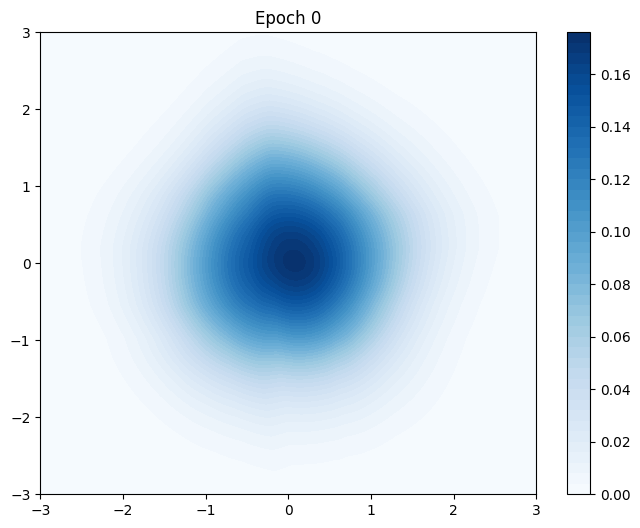

Epoch [5/100], Loss: 1.9041


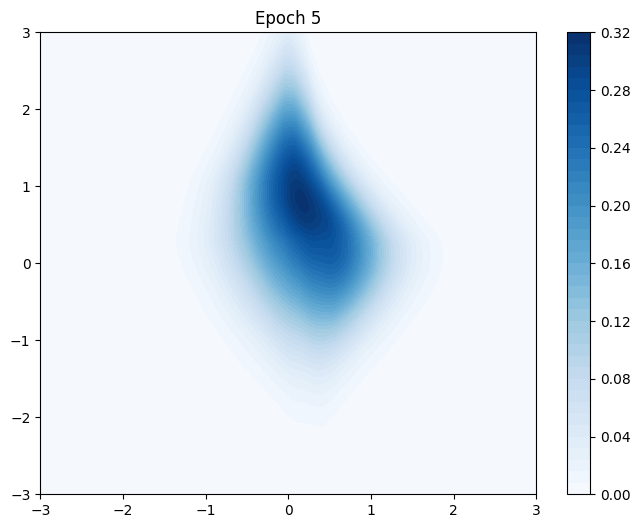

Epoch [10/100], Loss: 1.7784


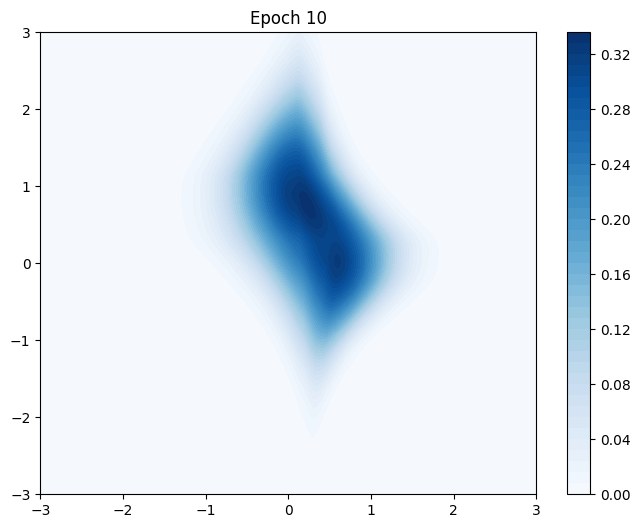

Epoch [15/100], Loss: 1.7353


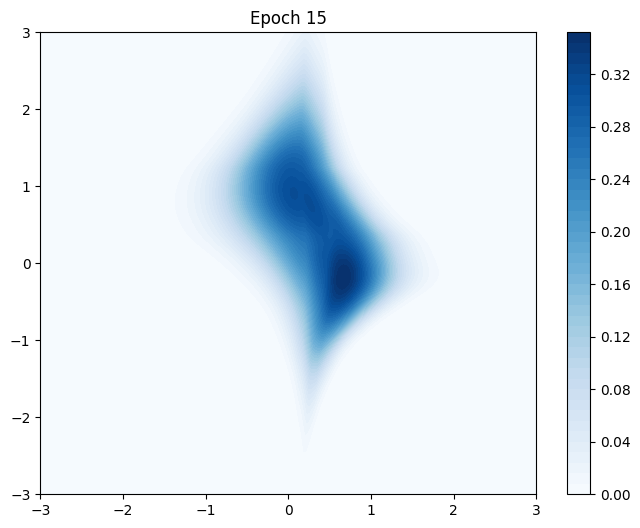

Epoch [20/100], Loss: 1.7105


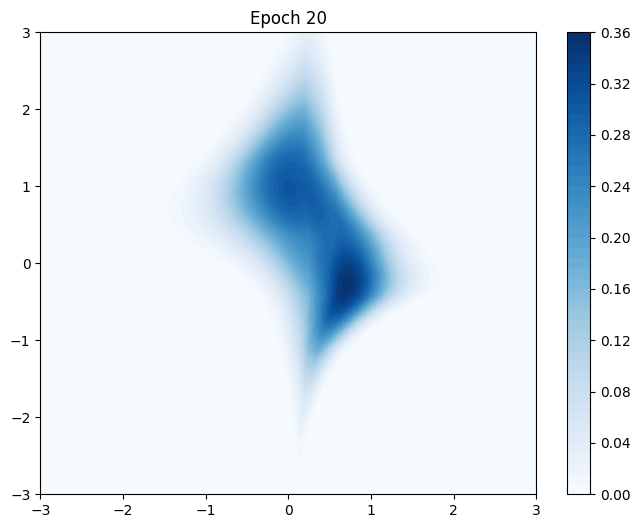

Epoch [25/100], Loss: 1.6879


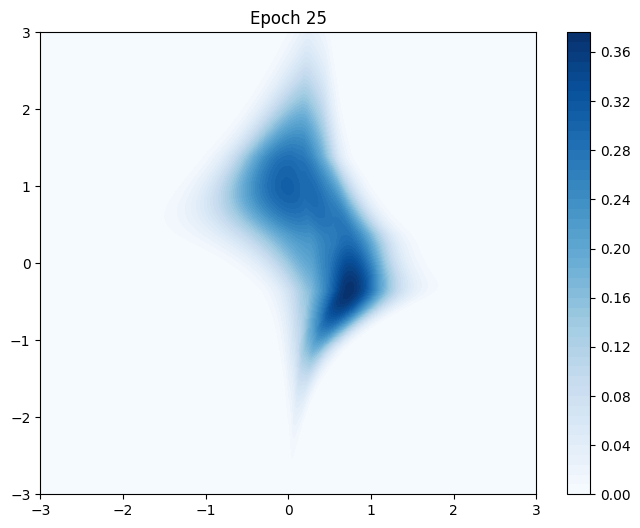

Epoch [30/100], Loss: 1.6680


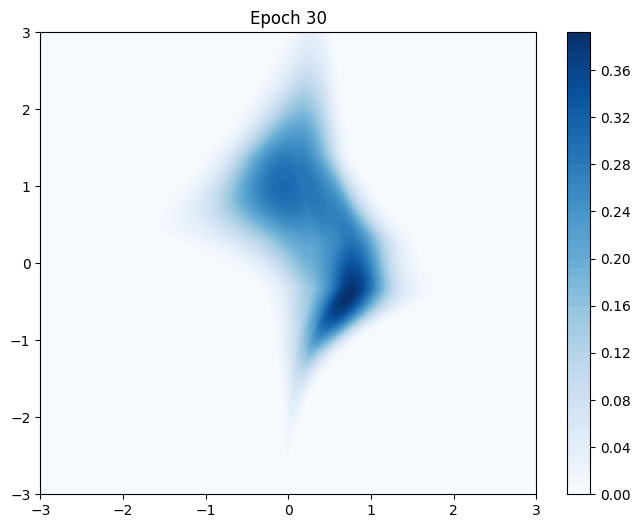

Epoch [35/100], Loss: 1.6390


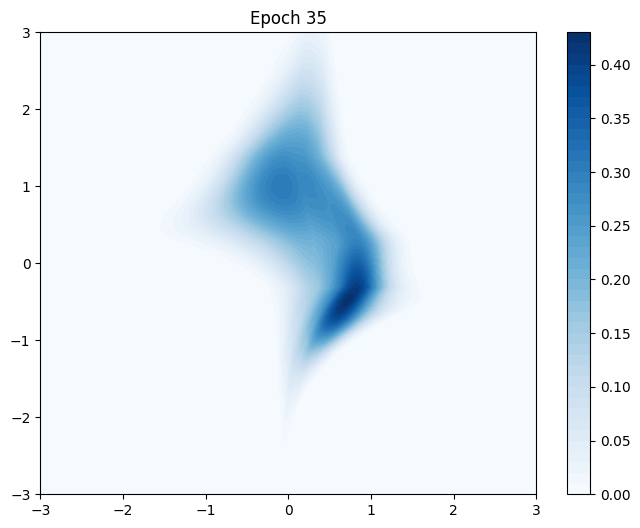

Epoch [40/100], Loss: 1.6169


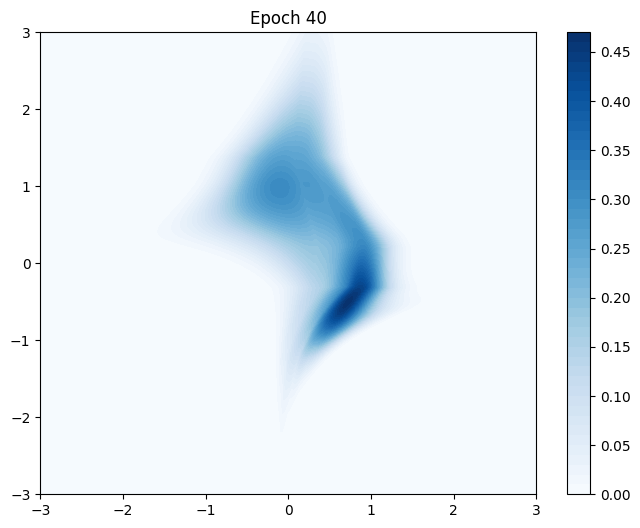

Epoch [45/100], Loss: 1.5983


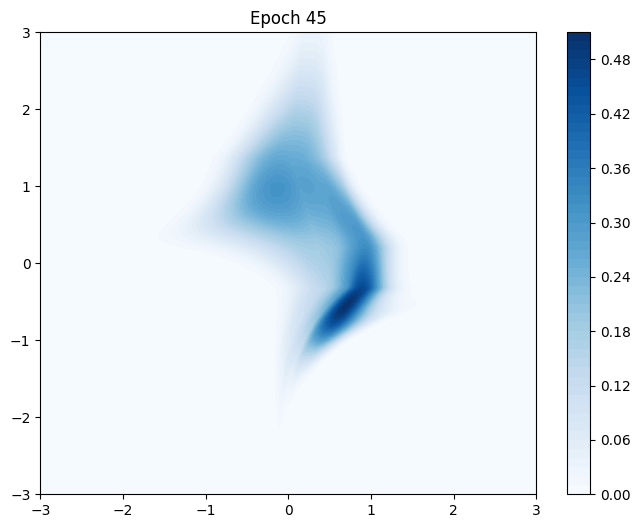

Epoch [50/100], Loss: 1.5801


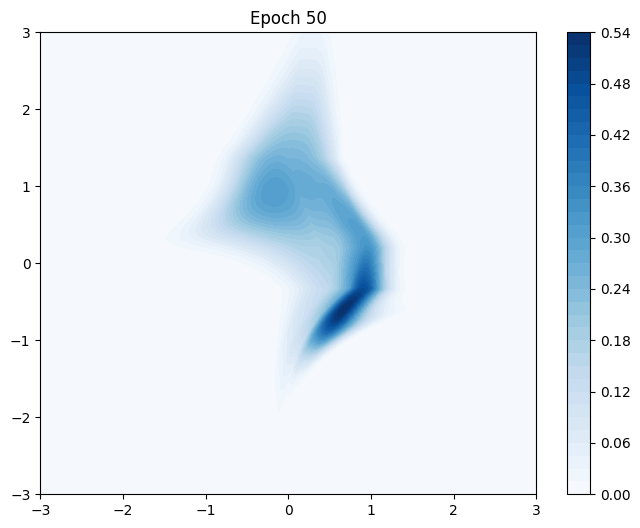

Epoch [55/100], Loss: 1.5607


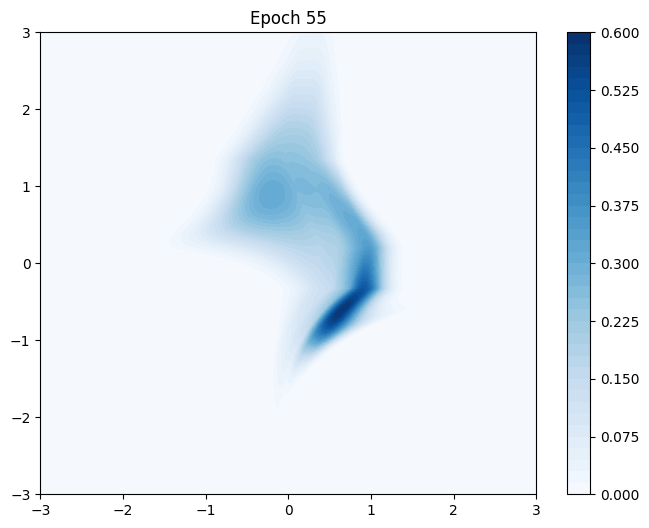

Epoch [60/100], Loss: 1.5470


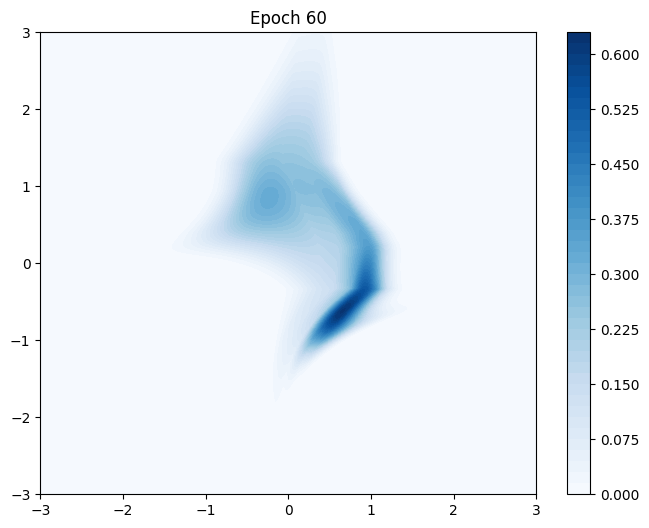

Epoch [65/100], Loss: 1.5277


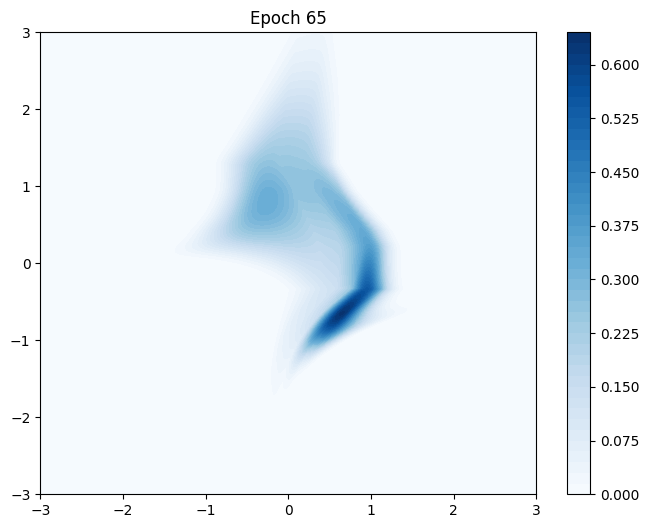

Epoch [70/100], Loss: 1.5188


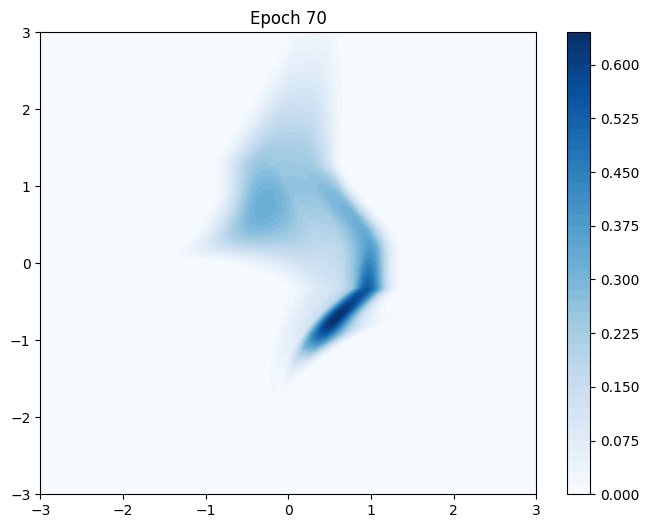

Epoch [75/100], Loss: 1.5013


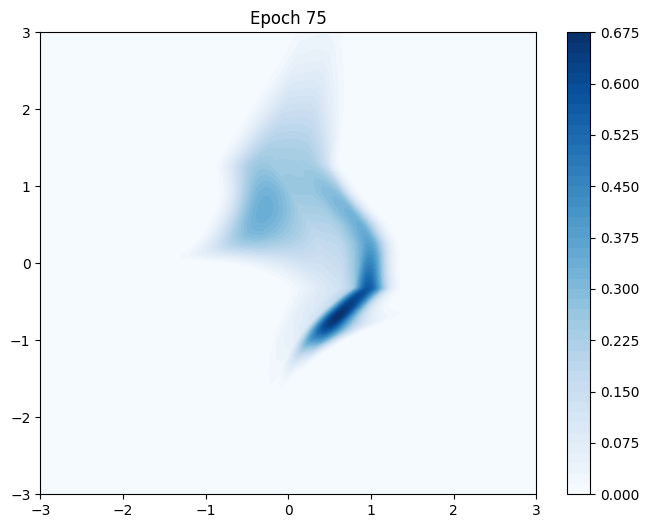

Epoch [80/100], Loss: 1.4917


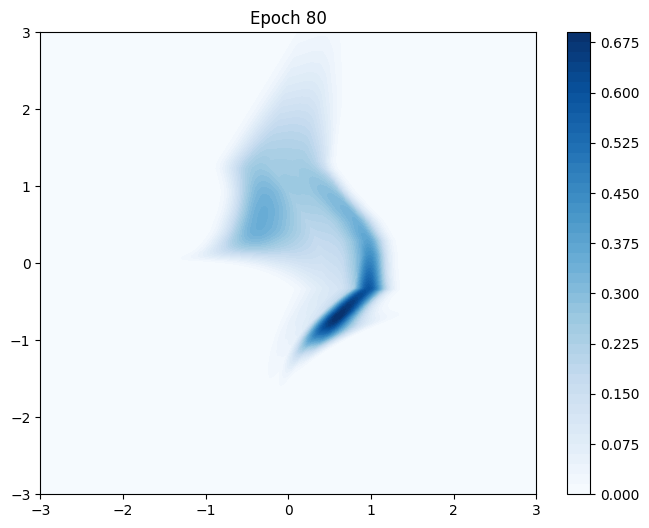

Epoch [85/100], Loss: 1.4799


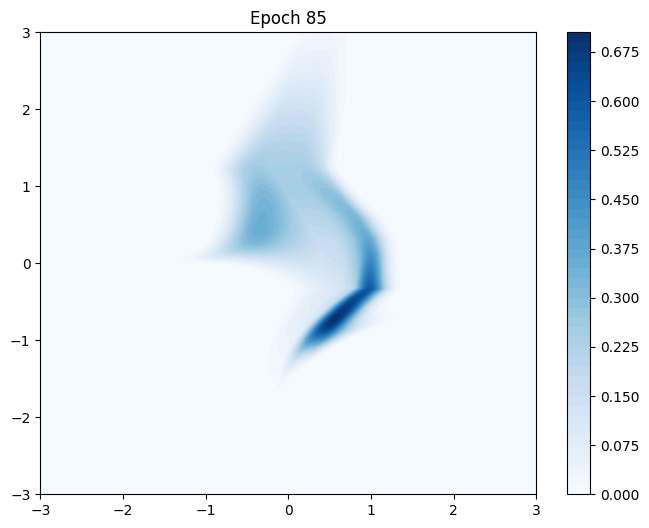

Epoch [90/100], Loss: 1.4697


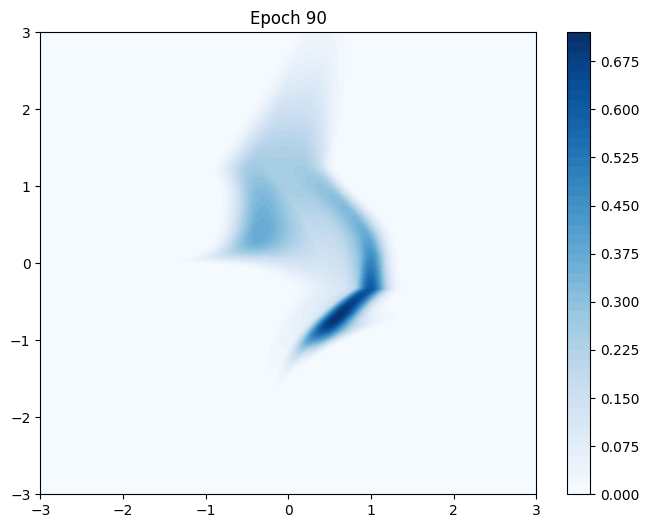

Epoch [95/100], Loss: 1.4610


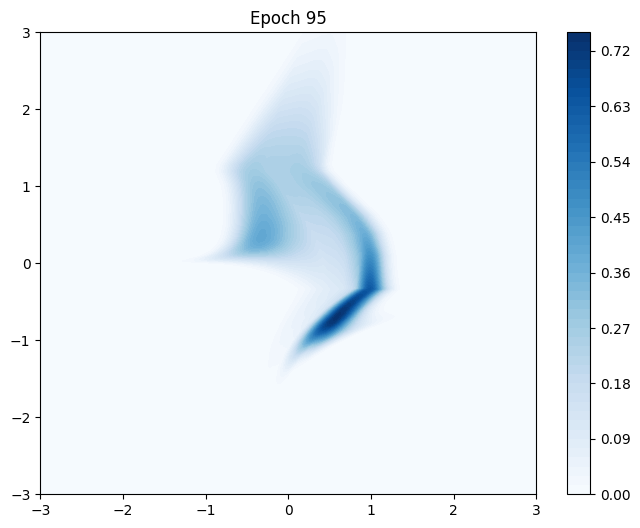

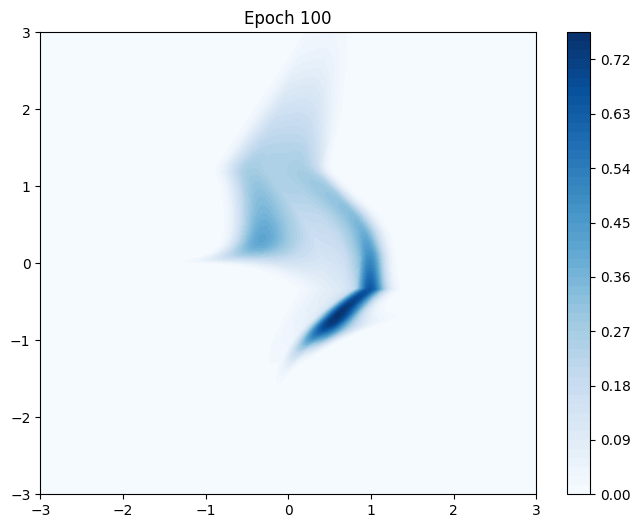

In [81]:
import torch
from torch.utils.data import DataLoader, TensorDataset


num_samples = 1000
X, _ = make_moons(n_samples=num_samples, noise=0.1)
x_train = torch.tensor(X, dtype=torch.float32)


batch_size = 64
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
log_interval = 5
loss_fn = torch.nn.MSELoss()


for epoch in range(num_epochs):
    flow.train()
    total_loss = 0.0

    for batch_idx, (x_batch,) in enumerate(train_loader):

        optimizer.zero_grad()


        z, log_det_J = flow(x_batch)


        log_prob = flow.log_prob(x_batch)


        loss = -log_prob.mean()
        total_loss += loss.item()


        loss.backward()
        optimizer.step()


    if epoch % log_interval == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
        visualize(flow, epoch)

visualize(flow, num_epochs)



# Visualizations (15 points)

Generate some datapoints using the original distribution and from your model and plot them together.

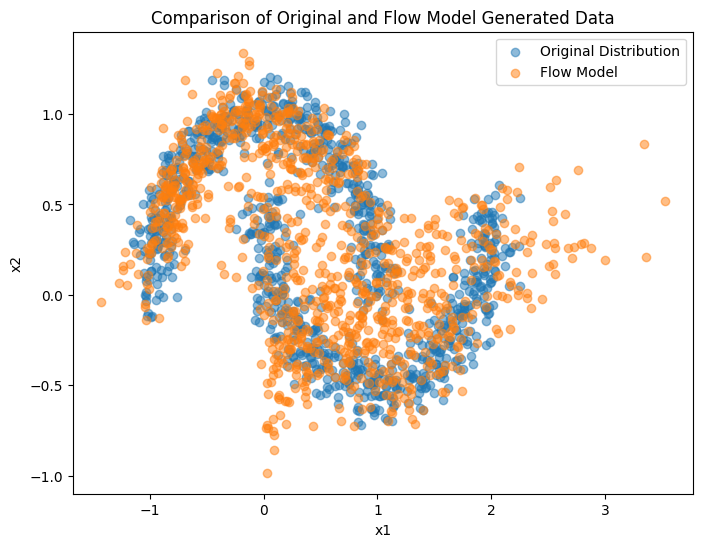

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

num_samples_original = 1000
X_original, _ = make_moons(n_samples=num_samples_original, noise=0.1)


num_samples_flow = 1000

X_flow = flow.sample(num_samples_flow)[:, :2].detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(X_original[:, 0], X_original[:, 1], label="Original Distribution", alpha=0.5)
plt.scatter(X_flow[:, 0], X_flow[:, 1], label="Flow Model", alpha=0.5)
plt.title("Comparison of Original and Flow Model Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

Visualize the evolution of the Normalizing Flows model.

In [87]:
path = create_gif()

<ipython-input-60-332d3e92a535>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


GIF saved at: flow_model_evolution.gif
